In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Precipitation Analysis

In [9]:
#Get the column names for measurement table
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Find the most recent date in the data set.
recent_date=session.query(measurement.date).order_by(measurement.date.desc()).first()
recent_date = dt.datetime.strptime(recent_date[0], '%Y-%m-%d').date()
recent_date

datetime.date(2017, 8, 23)

In [11]:
# Calculate the date one year from the last date in data set.
one_yr_prior = recent_date - dt.timedelta(days=365)
one_yr_prior

datetime.date(2016, 8, 23)

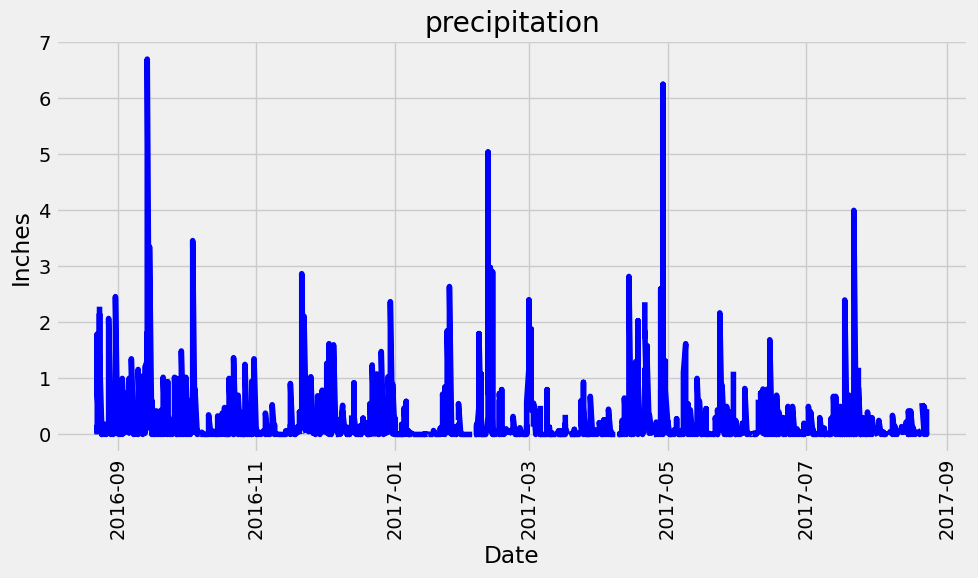

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

prcp_scores = session.query(measurement.date, measurement.prcp). \
            filter(measurement.date >= one_yr_prior).order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df=pd.DataFrame(prcp_scores, columns =['Date', 'Precipitation'])
prcp_df['Date'] = pd.to_datetime(prcp_df['Date'])

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title("precipitation")
plt.plot(prcp_df['Date'], prcp_df['Precipitation'], color='b')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,Date,Precipitation
count,2230,2021.000000
mean,2017-02-16 05:31:15.874439424,0.177279
min,2016-08-23 00:00:00,0.000000
25%,2016-11-18 00:00:00,0.000000
50%,2017-02-14 12:00:00,0.020000
75%,2017-05-17 00:00:00,0.130000
max,2017-08-23 00:00:00,6.700000
std,NaN,0.461190


# Exploratory Station Analysis

In [18]:
# Get the column names in 'station' table
columns_s = inspector.get_columns('station')
for c in columns_s:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [19]:
# Design a query to calculate the total number of stations in the dataset
session.query(station.station).count()

9

In [24]:

# Design a query to find the most active stations (i.e. which stations have the most rows?) 
# List the stations and their counts in descending order.
station_counts = (
    session.query(measurement.station, func.count(measurement.station).label('count'))
    .group_by(measurement.station)
    .order_by(func.count(measurement.station).desc())
    .all()
)

# Display the results
for station, count in station_counts:
    print(f"{station}, {count}")


USC00519281, 2772
USC00519397, 2724
USC00513117, 2709
USC00519523, 2669
USC00516128, 2612
USC00514830, 2202
USC00511918, 1979
USC00517948, 1372
USC00518838, 511


In [29]:
# Get the station with most rows
most_active_station = (
    session.query(measurement.station, func.count(measurement.station).label('count'))
    .group_by(measurement.station)
    .order_by(func.count(measurement.station).desc())
    .first() 
)
print(f"The station with the greatest number of observations: {most_active_station[0]} : {most_active_station[1]}")

The station with the greatest number of observations: USC00519281 : 2772


In [30]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_stats = (
    session.query(
        func.min(measurement.tobs).label("lowest_temp"),
        func.avg(measurement.tobs).label("avg_temp"),
        func.max(measurement.tobs).label("highest_temp")
    )
    .filter(measurement.station == "USC00519281")
    .first()
)
lowest_temp = temp_stats.lowest_temp
avg_temp = temp_stats.avg_temp
highest_temp = temp_stats.highest_temp
print(f"Station {most_active_station[0]} lowest_temp: {lowest_temp}, highest_temp: {highest_temp}, avg temp: {avg_temp}")

Station USC00519281 lowest_temp: 54.0, highest_temp: 85.0, avg temp: 71.66378066378067


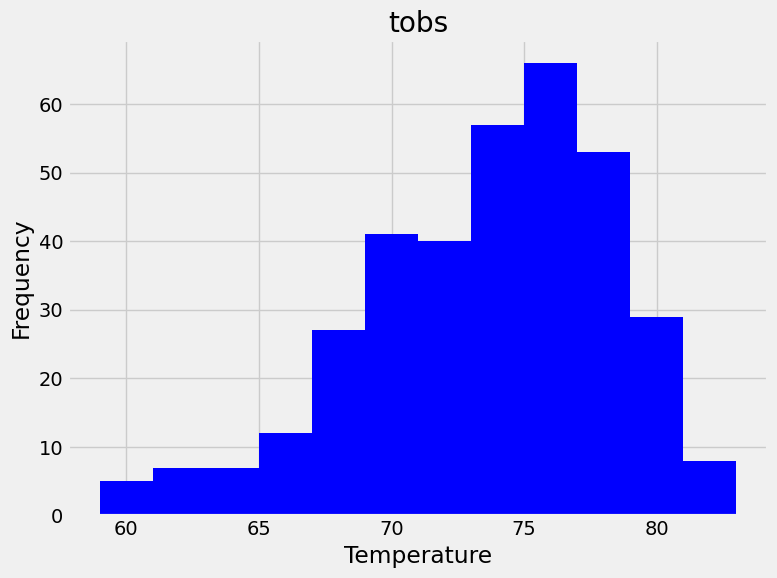

In [31]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

station_id = "USC00519281"
temp_data = (
    session.query(measurement.tobs)
    .filter(measurement.station == station_id)
    .filter(measurement.date >= one_yr_prior)
    .all()
)

# Extract temperatures into a list
temperatures = [temp[0] for temp in temp_data]

# Plot the results as a histogram
plt.figure(figsize=(8, 6))  
plt.hist(temperatures, bins=12, color='b')
plt.title("tobs")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


# Close Session

In [32]:
# Close Session
session.close()